# #5: CP Lateral position correction

# Position correction in real-space ptychography

This tutorial explains how to use position correction in ptyLab

Last updated: 22nd June 2021

# Position correction algorithm

The position correction code implemented in ptyLab is a modified version of the position correction algorithm described in

- Zhang, Fucai, et al. "Translation position determination in ptychographic coherent diffraction imaging." Optics express 21.11 (2013): 13592-13606.

We recommend citing that paper when using position correction for your results.

The main idea of the algorithm is based on the observation that the object update inside ePIE is slightly shifted towards the true position of each respective object patch. Therefore, the authors use registration to determine the relative shift between each object patch estimate before and after ePIE. Let $\textbf{d}_k=(\Delta_{x,k}, \,\Delta_{y,k})^T$ be the relative shift (in units of pixels) between the object before and after ePIE (at the $k^{th}$ position). This signal may be used to provide a feedback on the position estimate $\textbf{t}_k$ at the respective position. The updated estimated position at position $k$ and iteration $n$ is then given by
$\textbf{t}_{n,k} = \textbf{t}_{n−1,k}+\gamma \textbf{d}_{k,n}.$

# Modification in ptyLab

In ptyLab we use an adam (*) optimizer to speed up the convergence rate of Zhang's position correction algorithm. At the point of this writing, we have not carried out exhaustive hyperparameter tests, but observe a convergence speed up. Please e-mail us if you have suggestions for optimal parameters.

The adam update rule for our position correction is given recursively by the equations
$\textbf{d}_k= \delta \cdot (\Delta_{x,k} ,\,\Delta_{y,k})^T + (1−\delta)\cdot \textbf{d}_{k−1}$,

$s^2_k = \beta s^2_{k−1} + (1−\beta)∥\textbf{d}_k∥^2$,

where we observed a good convergence rate for  $\gamma=0.5$ , $\beta=0.999$, and  $s_0=1$ .

For more information on adam, see:

(*) Kingma, Diederik P., and Jimmy Ba. "Adam: A method for stochastic optimization." arXiv preprint arXiv:1412.6980 (2014).

# exampleReconstruction_pcPIE.py

In exampleReconstruction_pcPIE.py you find an example of position correction carried out in ptyLab. We used the simulation code explained in Tutorial #1 to generate an artificial data set. The data set is saved as 'simu.hdf5'.

First, we import the libraries and initialize the objects exampleData and reconstruction. 

In [10]:
%matplotlib notebook
import matplotlib
# matplotlib.use('tkagg')
import PtyLab
from PtyLab.io import getExampleDataFolder
import logging
logging.basicConfig(level=logging.INFO)
import numpy as np
from PtyLab import Params
from PtyLab import Monitor
from PtyLab import Reconstruction
from PtyLab import ExperimentalData
from PtyLab import Engines

""" 
ptycho data reconstructor 
change data visualization and initialization options manually for now
"""


fileName = 'simu.hdf5'  # generate the simu.hdf5 from the simulation tutorial
filePath = getExampleDataFolder() / fileName


In [11]:
# easy initialization
exampleData, reconstruction, params, monitor, ePIE_engine = PtyLab.easyInitialize(filePath)

ERROR:Reconstruction:Copying attribute wavelength
ERROR:Reconstruction:Copying attribute dxd
ERROR:Reconstruction:Copying attribute theta
ERROR:Reconstruction:Copying attribute spectralDensity
ERROR:Reconstruction:Copying attribute entrancePupilDiameter
INFO:Reconstruction:Changing sample-detector distance to 0.05000000074505806
INFO:Reconstruction:Initial object set to ones
INFO:Reconstruction:Initial probe set to circ
INFO:ePIE:Sucesfully created ePIE ePIE_engine
INFO:ePIE:Wavelength attribute: 6.327999813038332e-07


Before the reconstruction is started, we perturb the scan grid, using the following commands.
These lines produce the following plot. The blue points are the correct scan grid. The yellow points are the perturbed scan grid. 

<IPython.core.display.Javascript object>


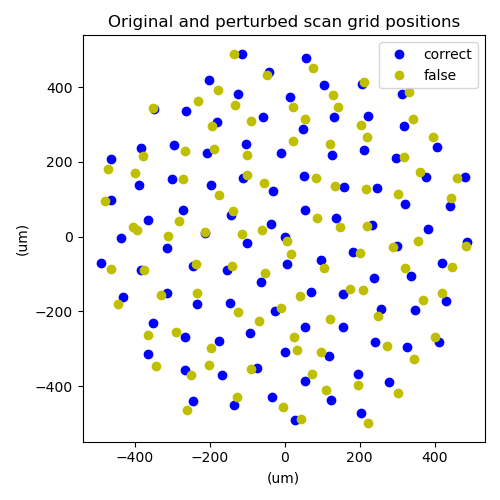

In [12]:
# perturb encoder positions
maxPosError = 10
encoder0 = exampleData.encoder.copy()
exampleData.encoder = encoder0 + maxPosError * reconstruction.dxo * (2*np.random.rand(encoder0.shape[0], encoder0.shape[1]) - 1)
import matplotlib.pyplot as plt
figure, ax = plt.subplots(1, 1, num=112, squeeze=True, clear=True, figsize=(5, 5))
ax.set_title('Original and perturbed scan grid positions')
ax.set_xlabel('(um)')
ax.set_ylabel('(um)')
line1, = plt.plot(encoder0[:, 1] * 1e6,
         encoder0[:, 0] * 1e6, 'bo', label='correct')
line2, = plt.plot(exampleData.encoder[:, 1] * 1e6,
         exampleData.encoder[:, 0] * 1e6, 'yo', label='false')
plt.legend(handles=[line1, line2])
plt.tight_layout()
plt.show(block=False)

We use the incorrect scan grid as an input for the reconstruction. After altering the encoder data, we need to reset the reconstruction with the perturbed data as original data.

In [15]:
#initialize again reconstruction with the wrong encoder data
reconstruction = Reconstruction(exampleData, params)

ERROR:Reconstruction:Copying attribute wavelength
ERROR:Reconstruction:Copying attribute dxd
ERROR:Reconstruction:Copying attribute theta
ERROR:Reconstruction:Copying attribute spectralDensity
ERROR:Reconstruction:Copying attribute entrancePupilDiameter
INFO:Reconstruction:Changing sample-detector distance to 0.05000000074505806


Now we can set initial values for variables included in the reconstruction, monitor and in params and run ePIE, exactly like in Tutorial #2. 

In [16]:
exampleData.showPtychogram()

Min max ptychogram: 2.462452171423518e-14, 32837.0
Min max ptychogram: 1.0704034878741355e-14, 4.516376698526149
1.0704034878741355e-14 4.516376698526149


In [17]:
# now, all our experimental data is loaded into experimental_data and we don't have to worry about it anymore.
# now create an object to hold everything we're eventually interested in
reconstruction.npsm = 1 # Number of probe modes to reconstruct
reconstruction.nosm = 1 # Number of object modes to reconstruct
reconstruction.nlambda = 1 # len(exampleData.spectralDensity) # Number of wavelength
reconstruction.nslice = 1 # Number of object slice


reconstruction.initialProbe = 'circ'
exampleData.entrancePupilDiameter = reconstruction.Np / 3 * reconstruction.dxp  # initial estimate of beam diameter
reconstruction.initialObject = 'ones'
# initialize probe and object and related params
reconstruction.initializeObjectProbe()

# customize initial probe quadratic phase
reconstruction.probe = reconstruction.probe*np.exp(1.j*2*np.pi/reconstruction.wavelength *
                                             (reconstruction.Xp**2+reconstruction.Yp**2)/(2*6e-3))

# this will copy any attributes from experimental data that we might care to optimize
# # Set monitor properties
monitor = Monitor()
monitor.figureUpdateFrequency = 1
monitor.objectPlot = 'complex'  # complex abs angle
monitor.verboseLevel = 'high'  # high: plot two figures, low: plot only one figure
monitor.objectPlotZoom = 1.5   # control object plot FoV
monitor.probePlotZoom = 0.5   # control probe plot FoV

# Run the reconstruction

params = Params()
## main parameters
params.positionOrder = 'random'  # 'sequential' or 'random'
params.propagator = 'Fresnel'  # Fraunhofer Fresnel ASP scaledASP polychromeASP scaledPolychromeASP


## how do we want to reconstruct?
params.gpuSwitch = True
params.probePowerCorrectionSwitch = True
params.modulusEnforcedProbeSwitch = False
params.comStabilizationSwitch = True
params.orthogonalizationSwitch = False
params.orthogonalizationFrequency = 10
params.fftshiftSwitch = False
params.intensityConstraint = 'standard'  # standard fluctuation exponential poission
params.absorbingProbeBoundary = False
params.objectContrastSwitch = False
params.absObjectSwitch = False
params.backgroundModeSwitch = False
params.couplingSwitch = True
params.couplingAleph = 1
params.positionCorrectionSwitch = False


INFO:Reconstruction:Initial object set to ones
INFO:Reconstruction:Initial probe set to circ


If you use ePIE, this is what we get: 

In [18]:
ePIE_engine = Engines.ePIE(reconstruction, exampleData, params, monitor)
## choose engine
# ePIE
engine_ePIE = Engines.ePIE(reconstruction, exampleData, params,monitor)
engine_ePIE.numIterations = 50
engine_ePIE.betaProbe = 0.25
engine_ePIE.betaObject = 0.25
engine_ePIE.reconstruct()

INFO:ePIE:Sucesfully created ePIE ePIE_engine
INFO:ePIE:Wavelength attribute: 6.327999813038332e-07
INFO:ePIE:Sucesfully created ePIE ePIE_engine
INFO:ePIE:Wavelength attribute: 6.327999813038332e-07


<generator object ePIE.reconstruct at 0x000001FD69673970>

To improve this, select the position correction engine. First, we reset the guesses for the probe and the object to the initial ones ('circ' for the probe and 'ones' for the object). The pcPIE engine has inherently the feature for momentum acceleration in the reconstruction of the object and the probe, therefore, if you want to compare it with ePIE, you need to turn off the momentum update. Also, position correction actually starts after $startAtIteration$ iterations. The default value is 20. With pcPIE and momentum accelaration, this is what we get:

INFO:Reconstruction:Initial object set to ones
INFO:Reconstruction:Initial probe set to circ
INFO:pcPIE:Successfully created pcPIE pcPIE_engine
INFO:pcPIE:Wavelength attribute: 6.327999813038332e-07
d:\du\ptylab\PtyLab\Engines\BaseEngine.py:376: UserWarning: fftshiftSwitch set to false, this may lead to reduced performance
  warnings.warn(


<IPython.core.display.Javascript object>


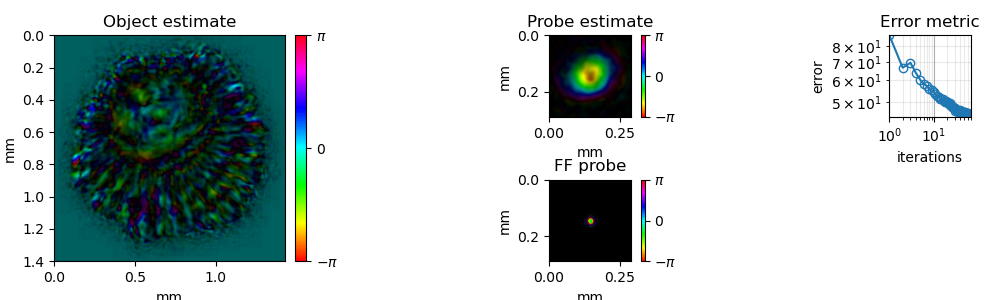

<IPython.core.display.Javascript object>


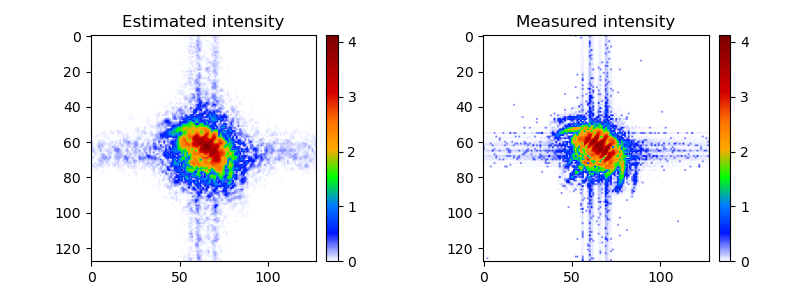

INFO:pcPIE:switch to gpu


pcPIE:   0%|                                                                                    | 0/70 [00:00<?, ?it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 0                                                                                                           
error: 87.4                                                                                                            
estimated linear overlap: 21.7 %                                                                                       
estimated area overlap: 57.4 %                                                                                         
pcPIE:   1%|█                                                                           | 1/70 [00:00<00:47,  1.45it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 1                                                                                                           
error: 66.7                                                                                                            
estimated linear overlap: 22.7 %                                                                                       
estimated area overlap: 54.2 %                                                                                         
pcPIE:   3%|██▏                                                                         | 2/70 [00:01<00:37,  1.80it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 2                                                                                                           
error: 69.5                                                                                                            
estimated linear overlap: 18.6 %                                                                                       
estimated area overlap: 48.9 %                                                                                         
pcPIE:   4%|███▎                                                                        | 3/70 [00:01<00:33,  1.99it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 3                                                                                                           
error: 63.7                                                                                                            
estimated linear overlap: 20.0 %                                                                                       
estimated area overlap: 46.1 %                                                                                         
pcPIE:   6%|████▎                                                                       | 4/70 [00:02<00:31,  2.10it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 4                                                                                                           
error: 60.2                                                                                                            
estimated linear overlap: 15.7 %                                                                                       
estimated area overlap: 52.4 %                                                                                         
pcPIE:   7%|█████▍                                                                      | 5/70 [00:02<00:29,  2.22it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 5                                                                                                           
error: 58.2                                                                                                            
estimated linear overlap: 13.5 %                                                                                       
estimated area overlap: 47.1 %                                                                                         
pcPIE:   9%|██████▌                                                                     | 6/70 [00:02<00:28,  2.23it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 6                                                                                                           
error: 57.3                                                                                                            
estimated linear overlap: 8.7 %                                                                                        
estimated area overlap: 45.9 %                                                                                         
pcPIE:  10%|███████▌                                                                    | 7/70 [00:03<00:27,  2.26it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 7                                                                                                           
error: 55.9                                                                                                            
estimated linear overlap: 12.6 %                                                                                       
estimated area overlap: 50.6 %                                                                                         
pcPIE:  11%|████████▋                                                                   | 8/70 [00:03<00:27,  2.30it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 8                                                                                                           
error: 55.1                                                                                                            
estimated linear overlap: 10.2 %                                                                                       
estimated area overlap: 46.3 %                                                                                         
pcPIE:  13%|█████████▊                                                                  | 9/70 [00:04<00:26,  2.33it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 9                                                                                                           
error: 54.6                                                                                                            
estimated linear overlap: 4.5 %                                                                                        
estimated area overlap: 49.5 %                                                                                         
pcPIE:  14%|██████████▋                                                                | 10/70 [00:04<00:25,  2.38it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 10                                                                                                          
error: 53.6                                                                                                            
estimated linear overlap: 5.4 %                                                                                        
estimated area overlap: 51.4 %                                                                                         
pcPIE:  16%|███████████▊                                                               | 11/70 [00:04<00:24,  2.41it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 11                                                                                                          
error: 52.6                                                                                                            
estimated linear overlap: 7.7 %                                                                                        
estimated area overlap: 49.3 %                                                                                         
pcPIE:  17%|████████████▊                                                              | 12/70 [00:05<00:23,  2.45it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 12                                                                                                          
error: 52.1                                                                                                            
estimated linear overlap: 5.0 %                                                                                        
estimated area overlap: 50.1 %                                                                                         
pcPIE:  19%|█████████████▉                                                             | 13/70 [00:05<00:22,  2.48it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 13                                                                                                          
error: 51.3                                                                                                            
estimated linear overlap: 1.8 %                                                                                        
estimated area overlap: 50.7 %                                                                                         
pcPIE:  20%|███████████████                                                            | 14/70 [00:06<00:22,  2.51it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 14                                                                                                          
error: 51.3                                                                                                            
estimated linear overlap: 1.3 %                                                                                        
estimated area overlap: 47.4 %                                                                                         
pcPIE:  21%|████████████████                                                           | 15/70 [00:06<00:22,  2.47it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 15                                                                                                          
error: 51.1                                                                                                            
estimated linear overlap: 3.1 %                                                                                        
estimated area overlap: 46.4 %                                                                                         
pcPIE:  23%|█████████████████▏                                                         | 16/70 [00:06<00:22,  2.40it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 16                                                                                                          
error: 50.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 48.6 %                                                                                         
pcPIE:  24%|██████████████████▏                                                        | 17/70 [00:07<00:22,  2.40it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 17                                                                                                          
error: 50.1                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 49.7 %                                                                                         
pcPIE:  26%|███████████████████▎                                                       | 18/70 [00:07<00:21,  2.40it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 18                                                                                                          
error: 50.4                                                                                                            
estimated linear overlap: 2.0 %                                                                                        
estimated area overlap: 45.4 %                                                                                         
pcPIE:  27%|████████████████████▎                                                      | 19/70 [00:08<00:21,  2.37it/s]

INFO:pcPIE:Doing probe com stabilization


                                                                                                                       
iteration: 19                                                                                                          
error: 49.9                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 52.1 %                                                                                         
pcPIE:  29%|█████████████████████▍                                                     | 20/70 [00:08<00:22,  2.24it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 20                                                                                                          
error: 49.6                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 50.4 %                                                                                         
pcPIE:  30%|██████████████████████▌                                                    | 21/70 [00:09<00:22,  2.21it/s]

d:\du\ptylab\PtyLab\Engines\BaseEngine.py:1237: ComplexWarning: Casting complex values to real discards the imaginary part
  cc[shifts] = xp.squeeze(
INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 21                                                                                                          
error: 49.4                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 44.9 %                                                                                         
pcPIE:  31%|███████████████████████▌                                                   | 22/70 [00:11<00:41,  1.15it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 22                                                                                                          
error: 49.7                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 50.3 %                                                                                         
pcPIE:  33%|████████████████████████▋                                                  | 23/70 [00:11<00:38,  1.23it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 23                                                                                                          
error: 48.7                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 46.4 %                                                                                         
pcPIE:  34%|█████████████████████████▋                                                 | 24/70 [00:12<00:35,  1.31it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 24                                                                                                          
error: 48.6                                                                                                            
estimated linear overlap: 2.0 %                                                                                        
estimated area overlap: 45.8 %                                                                                         
pcPIE:  36%|██████████████████████████▊                                                | 25/70 [00:13<00:32,  1.37it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 25                                                                                                          
error: 48.1                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 47.0 %                                                                                         
pcPIE:  37%|███████████████████████████▊                                               | 26/70 [00:13<00:31,  1.40it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 26                                                                                                          
error: 48.1                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 44.1 %                                                                                         
pcPIE:  39%|████████████████████████████▉                                              | 27/70 [00:14<00:30,  1.43it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 27                                                                                                          
error: 47.9                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 46.7 %                                                                                         
pcPIE:  40%|██████████████████████████████                                             | 28/70 [00:15<00:29,  1.45it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 28                                                                                                          
error: 47.5                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 42.2 %                                                                                         
pcPIE:  41%|███████████████████████████████                                            | 29/70 [00:15<00:27,  1.48it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 29                                                                                                          
error: 47.6                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 43.7 %                                                                                         
pcPIE:  43%|████████████████████████████████▏                                          | 30/70 [00:16<00:26,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 30                                                                                                          
error: 46.6                                                                                                            
estimated linear overlap: 0.7 %                                                                                        
estimated area overlap: 48.6 %                                                                                         
pcPIE:  44%|█████████████████████████████████▏                                         | 31/70 [00:17<00:25,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 31                                                                                                          
error: 46.9                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 44.6 %                                                                                         
pcPIE:  46%|██████████████████████████████████▎                                        | 32/70 [00:17<00:25,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 32                                                                                                          
error: 46.7                                                                                                            
estimated linear overlap: 2.0 %                                                                                        
estimated area overlap: 45.9 %                                                                                         
pcPIE:  47%|███████████████████████████████████▎                                       | 33/70 [00:18<00:24,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 33                                                                                                          
error: 46.5                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 46.5 %                                                                                         
pcPIE:  49%|████████████████████████████████████▍                                      | 34/70 [00:19<00:24,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 34                                                                                                          
error: 46.0                                                                                                            
estimated linear overlap: 2.5 %                                                                                        
estimated area overlap: 48.5 %                                                                                         
pcPIE:  50%|█████████████████████████████████████▌                                     | 35/70 [00:19<00:23,  1.48it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 35                                                                                                          
error: 46.5                                                                                                            
estimated linear overlap: 3.6 %                                                                                        
estimated area overlap: 48.5 %                                                                                         
pcPIE:  51%|██████████████████████████████████████▌                                    | 36/70 [00:20<00:22,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 36                                                                                                          
error: 46.4                                                                                                            
estimated linear overlap: 0.9 %                                                                                        
estimated area overlap: 43.5 %                                                                                         
pcPIE:  53%|███████████████████████████████████████▋                                   | 37/70 [00:21<00:22,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 37                                                                                                          
error: 45.9                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 47.2 %                                                                                         
pcPIE:  54%|████████████████████████████████████████▋                                  | 38/70 [00:21<00:21,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 38                                                                                                          
error: 45.4                                                                                                            
estimated linear overlap: 2.9 %                                                                                        
estimated area overlap: 48.5 %                                                                                         
pcPIE:  56%|█████████████████████████████████████████▊                                 | 39/70 [00:22<00:20,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 39                                                                                                          
error: 46.8                                                                                                            
estimated linear overlap: 8.2 %                                                                                        
estimated area overlap: 52.1 %                                                                                         
pcPIE:  57%|██████████████████████████████████████████▊                                | 40/70 [00:23<00:20,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 40                                                                                                          
error: 46.3                                                                                                            
estimated linear overlap: 0.4 %                                                                                        
estimated area overlap: 48.2 %                                                                                         
pcPIE:  59%|███████████████████████████████████████████▉                               | 41/70 [00:23<00:19,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 41                                                                                                          
error: 46.0                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 42.5 %                                                                                         
pcPIE:  60%|█████████████████████████████████████████████                              | 42/70 [00:24<00:18,  1.48it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 42                                                                                                          
error: 45.8                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 44.0 %                                                                                         
pcPIE:  61%|██████████████████████████████████████████████                             | 43/70 [00:25<00:18,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 43                                                                                                          
error: 46.0                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 45.5 %                                                                                         
pcPIE:  63%|███████████████████████████████████████████████▏                           | 44/70 [00:25<00:17,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 44                                                                                                          
error: 45.5                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 44.5 %                                                                                         
pcPIE:  64%|████████████████████████████████████████████████▏                          | 45/70 [00:26<00:16,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 45                                                                                                          
error: 45.9                                                                                                            
estimated linear overlap: 5.2 %                                                                                        
estimated area overlap: 46.9 %                                                                                         
pcPIE:  66%|█████████████████████████████████████████████████▎                         | 46/70 [00:27<00:15,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 46                                                                                                          
error: 46.0                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 48.2 %                                                                                         
pcPIE:  67%|██████████████████████████████████████████████████▎                        | 47/70 [00:27<00:15,  1.52it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 47                                                                                                          
error: 45.4                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 46.3 %                                                                                         
pcPIE:  69%|███████████████████████████████████████████████████▍                       | 48/70 [00:28<00:14,  1.52it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 48                                                                                                          
error: 45.9                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 45.0 %                                                                                         
pcPIE:  70%|████████████████████████████████████████████████████▌                      | 49/70 [00:29<00:14,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 49                                                                                                          
error: 45.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 43.0 %                                                                                         
pcPIE:  71%|█████████████████████████████████████████████████████▌                     | 50/70 [00:29<00:13,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 50                                                                                                          
error: 46.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 31.2 %                                                                                         
pcPIE:  73%|██████████████████████████████████████████████████████▋                    | 51/70 [00:30<00:12,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 51                                                                                                          
error: 45.4                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 31.7 %                                                                                         
pcPIE:  74%|███████████████████████████████████████████████████████▋                   | 52/70 [00:30<00:11,  1.52it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 52                                                                                                          
error: 45.8                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 33.7 %                                                                                         
pcPIE:  76%|████████████████████████████████████████████████████████▊                  | 53/70 [00:31<00:11,  1.52it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 53                                                                                                          
error: 45.8                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 31.6 %                                                                                         
pcPIE:  77%|█████████████████████████████████████████████████████████▊                 | 54/70 [00:32<00:11,  1.45it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 54                                                                                                          
error: 45.7                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 36.4 %                                                                                         
pcPIE:  79%|██████████████████████████████████████████████████████████▉                | 55/70 [00:33<00:10,  1.40it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 55                                                                                                          
error: 45.1                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 38.8 %                                                                                         
pcPIE:  80%|████████████████████████████████████████████████████████████               | 56/70 [00:33<00:09,  1.40it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 56                                                                                                          
error: 45.5                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 38.5 %                                                                                         
pcPIE:  81%|█████████████████████████████████████████████████████████████              | 57/70 [00:34<00:09,  1.41it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 57                                                                                                          
error: 45.0                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 37.7 %                                                                                         
pcPIE:  83%|██████████████████████████████████████████████████████████████▏            | 58/70 [00:35<00:08,  1.44it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 58                                                                                                          
error: 45.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 37.7 %                                                                                         
pcPIE:  84%|███████████████████████████████████████████████████████████████▏           | 59/70 [00:35<00:07,  1.47it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 59                                                                                                          
error: 45.1                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 33.7 %                                                                                         
pcPIE:  86%|████████████████████████████████████████████████████████████████▎          | 60/70 [00:36<00:06,  1.49it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 60                                                                                                          
error: 45.7                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 34.7 %                                                                                         
pcPIE:  87%|█████████████████████████████████████████████████████████████████▎         | 61/70 [00:37<00:05,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 61                                                                                                          
error: 45.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 39.6 %                                                                                         
pcPIE:  89%|██████████████████████████████████████████████████████████████████▍        | 62/70 [00:37<00:05,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 62                                                                                                          
error: 44.9                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 29.6 %                                                                                         
pcPIE:  90%|███████████████████████████████████████████████████████████████████▌       | 63/70 [00:38<00:04,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 63                                                                                                          
error: 44.9                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 28.3 %                                                                                         
pcPIE:  91%|████████████████████████████████████████████████████████████████████▌      | 64/70 [00:39<00:04,  1.48it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 64                                                                                                          
error: 44.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 28.4 %                                                                                         
pcPIE:  93%|█████████████████████████████████████████████████████████████████████▋     | 65/70 [00:39<00:03,  1.50it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 65                                                                                                          
error: 45.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 30.1 %                                                                                         
pcPIE:  94%|██████████████████████████████████████████████████████████████████████▋    | 66/70 [00:40<00:02,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 66                                                                                                          
error: 45.0                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 30.6 %                                                                                         
pcPIE:  96%|███████████████████████████████████████████████████████████████████████▊   | 67/70 [00:41<00:01,  1.52it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 67                                                                                                          
error: 44.7                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 30.2 %                                                                                         
pcPIE:  97%|████████████████████████████████████████████████████████████████████████▊  | 68/70 [00:41<00:01,  1.52it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 68                                                                                                          
error: 44.5                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 33.5 %                                                                                         
pcPIE:  99%|█████████████████████████████████████████████████████████████████████████▉ | 69/70 [00:42<00:00,  1.51it/s]

INFO:pcPIE:Doing probe com stabilization
INFO:pcPIE:Updating positions


                                                                                                                       
iteration: 69                                                                                                          
error: 44.2                                                                                                            
estimated linear overlap: 0.0 %                                                                                        
estimated area overlap: 31.8 %                                                                                         
pcPIE: 100%|███████████████████████████████████████████████████████████████████████████| 70/70 [00:43<00:00,  1.62it/s]

INFO:pcPIE:switch to cpu


In [19]:
#reset object and probe to initial guesses
reconstruction.initialProbe = 'circ'
exampleData.entrancePupilDiameter = reconstruction.Np / 3 * reconstruction.dxp  # initial estimate of beam diameter
reconstruction.initialObject = 'ones'
# initialize probe and object and related params
reconstruction.initializeObjectProbe()

# customize initial probe quadratic phase
reconstruction.probe = reconstruction.probe*np.exp(1.j*2*np.pi/reconstruction.wavelength *
                                             (reconstruction.Xp**2+reconstruction.Yp**2)/(2*6e-3))
reconstruction.error = []
params.positionCorrectionSwitch = True

engine_pcPIE = Engines.pcPIE(reconstruction, exampleData, params,monitor)
engine_pcPIE.numIterations = 70
engine_pcPIE.reconstruct()

The estimated scan grid (obtained from pcPIE) is shown by the yellow points in the following plot.

<IPython.core.display.Javascript object>


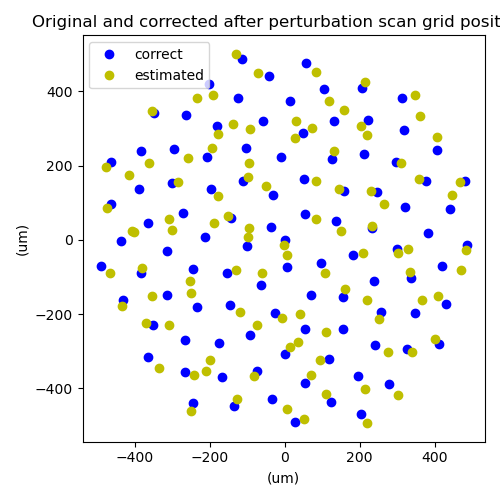

In [20]:
#compare original encoder and result from pcPIE
figure, ax = plt.subplots(1, 1, num=113, squeeze=True, clear=True, figsize=(5, 5))
ax.set_title('Original and corrected after perturbation scan grid positions')
ax.set_xlabel('(um)')
ax.set_ylabel('(um)')
line1, = plt.plot(encoder0[:, 1] * 1e6,
         encoder0[:, 0] * 1e6, 'bo', label='correct')
line2, = plt.plot((reconstruction.positions[:, 1] - reconstruction.No // 2 + reconstruction.Np // 2) * reconstruction.dxo * 1e6,
                  (reconstruction.positions[:, 0] - reconstruction.No // 2 + reconstruction.Np // 2) * reconstruction.dxo * 1e6, 'yo', label='estimated')
plt.legend(handles=[line1, line2])
plt.tight_layout()
plt.show(block=False)

We see that the positions estimated by pcPIE match "well" with the ground truth. There is some deviation left, but we can't always win. Finally, we can save the data.

In [21]:
# now save the data
# reconstruction.saveResults('simulation_ePIE_comparison_pcPIE.hdf5')